# Load dependencies

In [32]:
project_name = 'kornet'
import os
#get current working directory
cwd = os.getcwd()
git_dir = cwd.split(project_name)[0] + project_name
import sys

#add git_dir to path
sys.path.append(git_dir)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from glob import glob as glob
import pdb
import warnings
warnings.filterwarnings("ignore")

In [33]:
data_dir = f'{git_dir}/data'
results_dir = f'{git_dir}/results'
fig_dir = f'{git_dir}/figures'


sub_info = pd.read_csv(f'{data_dir}/sub_info.csv' )
#remove subjects with NaNs in code field
#sub_info = sub_info[~sub_info['code'].isna()]
#remove subjects with 1 in exclude field
sub_info = sub_info[sub_info['exclude'] != 1]


benchmark_models = ['vonenet_r_ecoset','vonenet_r_stylized-ecoset','vonenet_ff_ecoset','vonenet_ff_stylized-ecoset',
    'vonecornet_s','cornet_s','voneresnet', 'vit','convnext','resnet50','resnext50','alexnet','vgg19', 'ShapeNet','SayCam']

benchmark_models = ['vonenet_r_ecoset','vonenet_r_stylized-ecoset','vonenet_ff_ecoset','vonenet_ff_stylized-ecoset', 'ShapeNet','SayCam', 'vit','convnext']
conds = ['complete', 'perturbed','deleted']
model_conds = ['Outline','Pert','IC']
durations = [.3,.25, .2,.15,.1]
duration_labels = [300, 250, 200, 150, 100]
speed = ['intro','slow','slow','fast','fast']

age_groups = ['3yrold','4yrold','5yrold','adult']
#reverse list


#convert to hex
colors = sns.color_palette("deep")

all_colors_hex = [f'#{int(255*color[0]):02x}{int(255*color[1]):02x}{int(255*color[2]):02x}' for color in colors]


### Sumarize group info

In [3]:
#summarize sub info
print(f'Number of subjects: {len(sub_info)}')
print(f'Number of subjects per age group:')
print(sub_info.groupby('age_group').size())
print(f'Number of subjects per condition:')
print(sub_info.groupby('cond').size())

print(f'Number of subjects per sex:')
print(sub_info.groupby('sex').size())

#mean age and range
print(f'Mean age: {sub_info.age.mean()}')
print(f'Age range: {sub_info.age.min()} - {sub_info.age.max()}')

Number of subjects: 128
Number of subjects per age group:
age_group
3    38
4    45
5    45
dtype: int64
Number of subjects per condition:
cond
1    43
2    42
3    43
dtype: int64
Number of subjects per sex:
sex
F    65
M    63
dtype: int64
Mean age: 4.61453125
Age range: 3.05 - 5.95


### Create child summary files

In [4]:


sub_summary = pd.DataFrame(columns = ['sub','sex','age','cond','duration','acc','rt','imputed','top_speed'])

for sub in sub_info['sub']:

    sub_cond = sub_info[sub_info['sub']==sub]['cond'].values[0] -1 #subtract 1 because conditions are 1 2 3
    sub_file = glob(f'{data_dir}/{conds[sub_cond]}/{sub}_*.csv')
    #check if subfile is not empty
    if len(sub_file) != 0:
        to_impute = False #flag to check whether some data was imputed
        sub_file = sub_file[0]
    
        temp_summary = pd.DataFrame(columns = sub_summary.columns)
        #glob a file from cond with sub number
        

        #load sub data
        sub_data = pd.read_csv(sub_file)

        #remove practice trials
        sub_data = sub_data[sub_data['pracTrials.ran']!=1]
        acc = sub_data.groupby(['Duration'])['resp.corr'].mean().reset_index()
        rt = sub_data[sub_data['resp.corr']==1].groupby(['Duration'])['resp.rt'].mean().reset_index()
        sem = sub_data.groupby(['Duration'])['resp.corr'].sem()
        sem = sem.reset_index()
        


        temp_summary['acc'] = acc['resp.corr']
        temp_summary['rt'] = rt['resp.rt']
        temp_summary['duration']= acc['Duration']
        temp_summary['imputed'] = 0

        temp_summary['sub'] = sub
        temp_summary['cond'] = conds[sub_cond]
        temp_summary['age'] = sub_info[sub_info['sub']==sub]['age'].values[0]
        temp_summary['age_group'] = np.floor(sub_info[sub_info['sub']==sub]['age'].values[0]).astype(str)[:-2] + 'yrold'
        temp_summary['sex'] = sub_info[sub_info['sub']==sub]['sex'].values[0]

        #find fastest speed
        #this is reverse coded as duration
        top_speed = .3 - np.min(temp_summary['duration'])
        


        
        #loop through durations and check if there is data for each duration
        for dur in durations:
            
            if dur not in temp_summary['duration'].values:
                #add row for duration and fill with .5 - sem
                sem = sub_data['resp.corr'].sem()

                #add new row to temp_summary with .5 - sem for acc and np.nan for rt, all other values the same               
                temp_summary = pd.concat([temp_summary, 
                                         pd.DataFrame({'sub':[sub], 'cond':[conds[sub_cond]], 'age':[sub_info[sub_info['sub']==sub]['age'].values[0]],'age_group':[temp_summary['age_group'].values[0]],'sex': [sub_info[sub_info['sub']==sub]['sex'].values[0]],
                                                       'duration':[dur], 'acc':[.5 - sem], 'rt':[np.nan], 'imputed':[1]})])

                to_impute = True
        

        if to_impute == True:
            temp_summary['imputed'] = 1


        temp_summary['top_speed'] = top_speed
                   
        

        #check if acc for .3 duration is over .5
        #if temp_summary[temp_summary['duration']==.3]['acc'].values[0] > (.5+ sem['resp.corr'][sem['Duration'] == .30].values[0]):
        sub_summary = pd.concat([sub_summary, temp_summary], axis = 0)

        
        


    else:
        print(f'no file for {sub}')


#append column for speed
for i in range(len(durations)):
    sub_summary.loc[sub_summary['duration']==durations[i],'speed'] = speed[i]
    
    
#save long format    
sub_summary.to_csv(f'{results_dir}/group_data/sub_summary_long.csv', index = False)






no file for 6096
no file for 6123


In [5]:
#create new sub_info with only subjects that have data
sub_info = sub_info[sub_info['sub'].isin(sub_summary['sub'])]

#summarize sub info
print(f'Number of subjects: {len(sub_info)}')
print(f'Number of subjects per age group:')
print(sub_info.groupby('age_group').size())
print(f'Number of subjects per condition:')
print(sub_info.groupby('cond').size())

print(f'Number of subjects per sex:')
print(sub_info.groupby('sex').size())

#mean age and range
print(f'Mean age: {sub_info.age.mean()}')
print(f'Age range: {sub_info.age.min()} - {sub_info.age.max()}')

Number of subjects: 126
Number of subjects per age group:
age_group
3    37
4    45
5    44
dtype: int64
Number of subjects per condition:
cond
1    42
2    42
3    42
dtype: int64
Number of subjects per sex:
sex
F    64
M    62
dtype: int64
Mean age: 4.617301587301587
Age range: 3.05 - 5.95


In [6]:
'''Convert to wide format for analysis'''

sub_summary_wide = sub_summary



#Remove any durations over .35
sub_summary_wide = sub_summary_wide[sub_summary_wide['duration']<=.3]

#calculate sd across all kids
sd = sub_summary_wide['acc'].std() 


#first convert duration to string
sub_summary_wide['duration'] = sub_summary_wide['duration'].astype(str)
#convert age_group to string
sub_summary_wide['age_group'] = sub_summary_wide['age_group'].astype(str)
#convert imputed to string
sub_summary_wide['imputed'] = sub_summary_wide['imputed'].astype(str)
#convert top_speed to string
sub_summary_wide['top_speed'] = np.round(sub_summary_wide['top_speed'],2).astype(str)


sub_summary_wide = sub_summary_wide.groupby(['sub','cond','age','age_group','duration','imputed','top_speed'])['acc'].mean().reset_index()
sub_summary_wide = sub_summary_wide.pivot_table(index = ['sub','cond','age','age_group','imputed','top_speed'], columns = 'duration', values = 'acc').reset_index()

#save wide format
sub_summary_wide.to_csv(f'{results_dir}/group_data/sub_summary_wide.csv', index = False)
#loop through and save seperate files for complete, perturbed, and deleted
for cond in conds:
    temp = sub_summary_wide[sub_summary_wide['cond']==cond]
    temp.to_csv(f'{results_dir}/group_data/sub_summary_{cond}.csv', index = False)

### Creat adult summary

In [7]:
#glob csv files from adult fodler 
adult_files = glob(f'{data_dir}/adult/*.csv')

sub_summary = pd.DataFrame(columns = ['sub','sex','age','cond','duration','acc','rt','imputed','top_speed'])

for file in adult_files:
    to_impute = False
    sub = file.split('/')[-1].split('_')[0]
    cond = file.split('/')[-1].split('_')[3]

    sub_data = pd.read_csv(file)
    sub_data = sub_data[sub_data['pracTrials.ran']!=1]
    acc = sub_data.groupby(['Duration'])['resp.corr'].mean().reset_index()
    rt = sub_data[sub_data['resp.corr']==1].groupby(['Duration'])['resp.rt'].mean().reset_index()
    sem = sub_data.groupby(['Duration'])['resp.corr'].sem()
    sem = sem.reset_index()


    temp_summary = pd.DataFrame(columns = sub_summary.columns)
    temp_summary['acc'] = acc['resp.corr']
    temp_summary['rt'] = rt['resp.rt']
    temp_summary['duration']= acc['Duration']
    temp_summary['imputed'] = 0

    temp_summary['sub'] = sub
    temp_summary['cond'] = cond
    temp_summary['age'] = 30

    temp_summary['age_group'] = 'adult'

    top_speed = .3 - np.min(temp_summary['duration'])

    #loop through durations and check if there is data for each duration
    for dur in durations:
        
        if dur not in temp_summary['duration'].values:
            #add row for duration and fill with .5 - sem
            sem = sub_data['resp.corr'].sem()

            #add new row to temp_summary with .5 - sem for acc and np.nan for rt, all other values the same               
            temp_summary = pd.concat([temp_summary, 
                                        pd.DataFrame({'sub':[sub], 'cond':[conds[sub_cond]], 'age':[sub_info[sub_info['sub']==sub]['age'].values[0]],'age_group':[temp_summary['age_group'].values[0]],'sex': [sub_info[sub_info['sub']==sub]['sex'].values[0]],
                                                    'duration':[dur], 'acc':[.5 - sem], 'rt':[np.nan], 'imputed':[1]})])

            to_impute = True
    

    if to_impute == True:
        temp_summary['imputed'] = 1


    temp_summary['top_speed'] = top_speed
                
    

    #check if acc for .3 duration is over .5
    #if temp_summary[temp_summary['duration']==.3]['acc'].values[0] > (.5+ sem['resp.corr'][sem['Duration'] == .30].values[0]):
    sub_summary = pd.concat([sub_summary, temp_summary], axis = 0)

#append column for speed
for i in range(len(durations)):
    sub_summary.loc[sub_summary['duration']==durations[i],'speed'] = speed[i]


#save 
sub_summary.to_csv(f'{results_dir}/group_data/sub_summary_adult.csv', index = False)
    





In [8]:
#count number of unique subs in each condition
print(sub_summary.groupby('cond').sub.nunique())

cond
complete     10
deleted      10
perturbed     9
Name: sub, dtype: int64


### Combine child and adult data

In [10]:
'''Create long version of child and adult summary'''

#load data
child_summary = pd.read_csv(f'{results_dir}/group_data/sub_summary_long.csv')

#load adult data
adult_summary = pd.read_csv(f'{results_dir}/group_data/sub_summary_adult.csv')

#append adult data to sub_summary
sub_summary = pd.concat([child_summary, adult_summary], axis = 0)

In [12]:
'''Create wide version of child and adult summary'''
sub_summary_wide = sub_summary



#Remove any durations over .35
sub_summary_wide = sub_summary_wide[sub_summary_wide['duration']<=.3]



#calculate sd across all kids
sd = sub_summary_wide['acc'].std() 


#first convert duration to string
sub_summary_wide['duration'] = sub_summary_wide['duration'].astype(str)
#convert age_group to string
sub_summary_wide['age_group'] = sub_summary_wide['age_group'].astype(str)
#convert imputed to string
sub_summary_wide['imputed'] = sub_summary_wide['imputed'].astype(str)
#convert top_speed to string
sub_summary_wide['top_speed'] = np.round(sub_summary_wide['top_speed'],2).astype(str)


sub_summary_wide = sub_summary_wide.groupby(['sub','cond','age','age_group','duration','imputed','top_speed'])['acc'].mean().reset_index()
sub_summary_wide = sub_summary_wide.pivot_table(index = ['sub','cond','age','age_group','imputed','top_speed'], columns = 'duration', values = 'acc').reset_index()

#save wide format
sub_summary_wide.to_csv(f'{results_dir}/group_data/sub_summary_wide_with_adults.csv', index = False)
#loop through and save seperate files for complete, perturbed, and deleted
for cond in conds:
    temp = sub_summary_wide[sub_summary_wide['cond']==cond]
    temp.to_csv(f'{results_dir}/group_data/sub_summary_{cond}_with_adults.csv', index = False)


### Child Plotting func

In [7]:
from plotnine import *
def make_line_plot(summary, grouping, name, colors):
    #in plotnine create line graph with x = duration, y = accuracy, fill = cond
    p = ggplot(summary, aes(x='factor(duration)', y='acc', fill=grouping, group = grouping)) + \
        geom_line(aes(color = grouping), stat = 'summary', size = 1.5, position = position_dodge(width=.5)) + \
        geom_linerange(aes(color = grouping),stat = 'summary', size = 1.5, position = position_dodge(width=.5)) + \
        geom_point( stat = 'summary', size = 3, position = position_dodge(width=.5)) + \
        scale_fill_manual(values = colors) + \
        scale_color_manual(values = colors) + \
        xlab('Duration (ms)') + ylab('Accuracy') + \
            theme_classic() + ylim(.4,1) + geom_hline(yintercept = .5, linetype = 'dashed', color = 'black', size = 2) + \
            theme(text = element_text(color ='black'), 
                axis_text_x= element_text(size = 14),
                axis_text_y= element_text(size = 14),
                axis_title=element_text(size = 16),
                axis_line=element_line(), 
                panel_border=element_blank(),
                figure_size = (4,3))+ \
                theme(legend_position = 'none') + \
                labs(fill='Condition') #+ ggtitle(f'{cond}')
        

    #save
    p.save(f'{fig_dir}/{name}.png', dpi = 300)
    print(p)


### Make lineplots by age

Summary by condition


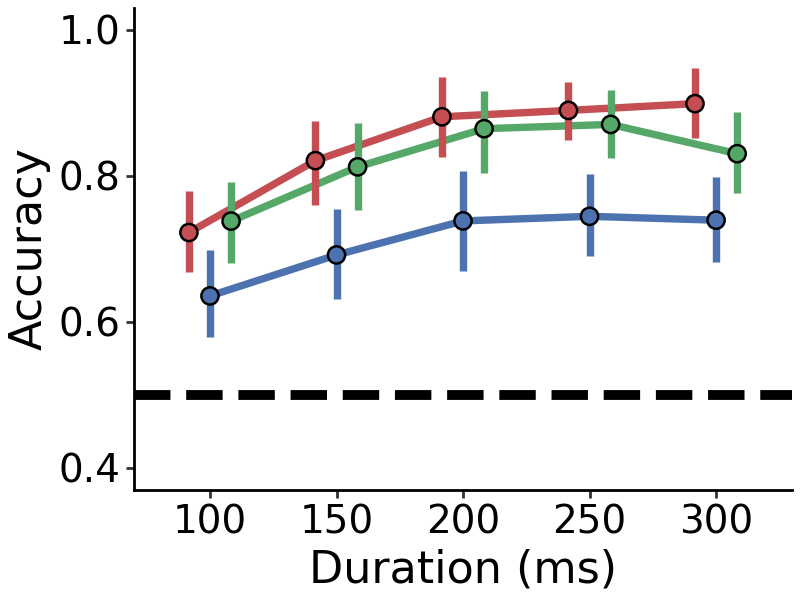


complete


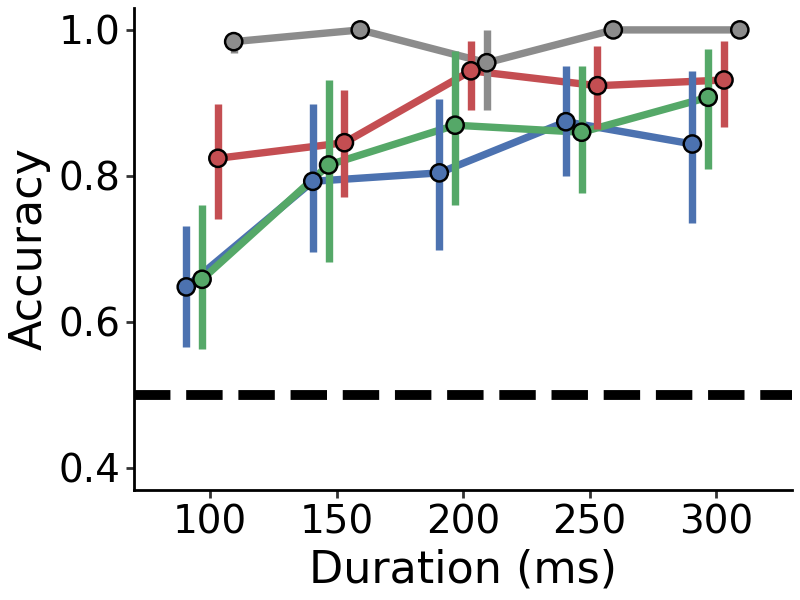


perturbed


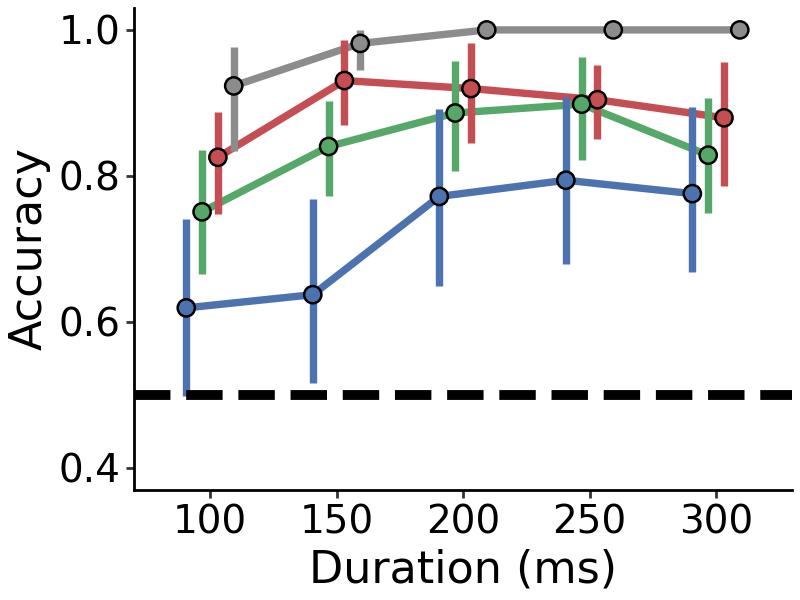


deleted


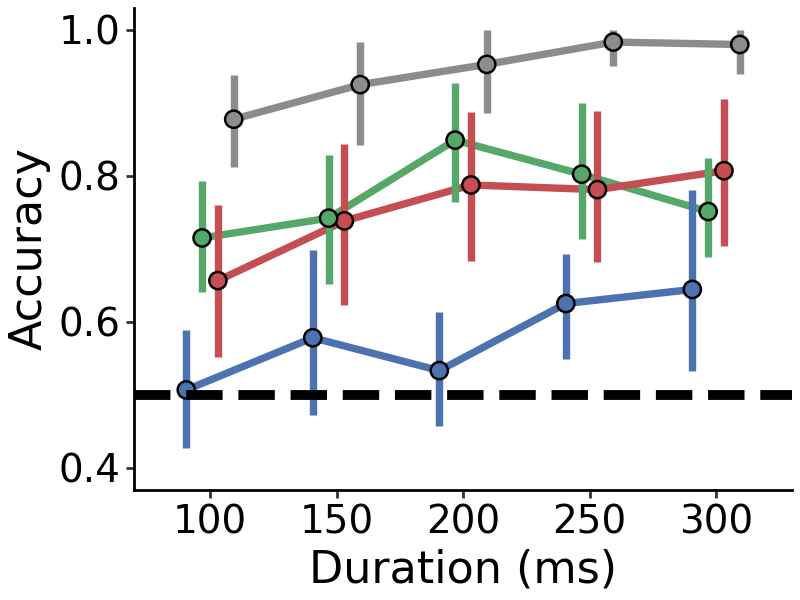

In [11]:
#load data
sub_summary = pd.read_csv(f'{results_dir}/group_data/sub_summary_long.csv')
#remove .35 duration
sub_summary = sub_summary[sub_summary['duration'] != .35]
#replace duration with duration label
sub_summary['duration'] = sub_summary['duration'].replace({.3:300, .25:250, .2:200, .15:150, .1:100})
#make duration integers
sub_summary['duration'] = sub_summary['duration'].astype(int)

#load adult data
sub_summary_adult = pd.read_csv(f'{results_dir}/group_data/sub_summary_adult.csv')

#replace duration with duration label
sub_summary_adult['duration'] = sub_summary_adult['duration'].replace({.3:300, .25:250, .2:200, .15:150, .1:100})
#make duration integers
sub_summary_adult['duration'] = sub_summary_adult['duration'].astype(int)





print('Summary by condition')
colors = [all_colors_hex[3],all_colors_hex[0],all_colors_hex[2]]
make_line_plot(sub_summary,'cond','summary_by_condition', colors)


#append adult data to sub_summary
sub_summary = pd.concat([sub_summary, sub_summary_adult], axis = 0)


#loop through conds and make line plots
for cond in conds:
    print(cond)
    kid_colors = [all_colors_hex[0],all_colors_hex[2],all_colors_hex[3],all_colors_hex[7]]
    sub_summary_cond = sub_summary[sub_summary['cond'] == cond]
    make_line_plot(sub_summary_cond,'age_group', f'{cond}_by_age_group',kid_colors)






## Split data by low/mid-level features

In [34]:
#load all_sub_data
all_sub_data = pd.read_csv(f'{results_dir}/all_sub_data.csv')

#extract just complete condition
#all_sub_data = all_sub_data[all_sub_data['cond'] == 'complete']

#remove .35 duration
all_sub_data = all_sub_data[all_sub_data['duration'] != .35]

In [35]:
#reset index
all_sub_data = all_sub_data.reset_index(drop = True)

In [36]:
#unique distractors
distractors = all_sub_data['distractor'].unique()

### add curvature data

In [37]:
# load curvature data
curv = pd.read_csv(f'{results_dir}/curvature_correlation_table.csv')

#add curvature col to all_sub_data
all_sub_data['curv'] = np.nan
#add curvature data to all_sub_data by object name
#if target == obj1_name then add zscore curvature to all_sub_data
for obj1, obj2, zscore in zip(curv['obj1_name'],curv['obj2_name'],curv['zscore']):
    all_sub_data.loc[(all_sub_data['target'] == obj1) & (all_sub_data['distractor'] == obj2), 'curv'] = zscore
    

#remove rows  with missing values
all_sub_data = all_sub_data[~all_sub_data['curv'].isna()]



#compute median curvature
curv_median = np.median(all_sub_data['curv'])

#add column for whether curvature is above or below median
all_sub_data['curv_med'] = 'low'
all_sub_data.loc[all_sub_data['curv'] > curv_median, 'curv_med'] = 'high'





### Add size data

In [38]:
#load size similarity data
size_data = pd.read_csv(f'{results_dir}/size_similarity.csv')

#add size similarity to all_sub_data
all_sub_data['conv_hull'] = np.nan
all_sub_data['axis_ratio'] = np.nan

for obj1, obj2, conv_hull, axis_ratio in zip(size_data['obj1'],size_data['obj2'],size_data['conv_hull_z'],size_data['ratio_diff_z']):
    all_sub_data.loc[(all_sub_data['target'] == obj1) & (all_sub_data['distractor'] == obj2), 'conv_hull'] = conv_hull
    all_sub_data.loc[(all_sub_data['target'] == obj1) & (all_sub_data['distractor'] == obj2), 'axis_ratio'] = axis_ratio

#remove rows  with missing values
all_sub_data = all_sub_data[~all_sub_data['conv_hull'].isna()]

#compute median size similarity
conv_hull_median = np.median(all_sub_data['conv_hull'])
axis_ratio_median = np.median(all_sub_data['axis_ratio'])

#add column for whether size similarity is above or below median
all_sub_data['conv_hull_med'] = 'low'
all_sub_data['axis_ratio_med'] = 'low'

all_sub_data.loc[all_sub_data['conv_hull'] < conv_hull_median, 'conv_hull_med'] = 'high'
all_sub_data.loc[all_sub_data['axis_ratio'] < axis_ratio_median, 'axis_ratio_med'] = 'high'


In [39]:
#remove intro speeds
#all_sub_data = all_sub_data[all_sub_data['speed'] != 'intro']

#create new column that combinees speed and curv_med, axis_ratio_med, and conv_hull_med
all_sub_data['speed_curv'] = all_sub_data['speed'] + '_' + all_sub_data['curv_med'] + '_curv'
all_sub_data['speed_conv_hull'] = all_sub_data['speed'] + '_' + all_sub_data['conv_hull_med'] + '_conv_hull'
all_sub_data['speed_axis_ratio'] = all_sub_data['speed'] + '_' + all_sub_data['axis_ratio_med'] + '_axis_ratio'



In [41]:
#groupby and convert to wide
curv_grouped = all_sub_data.groupby(['sub','age','age_group','cond','speed_curv'])['acc'].mean().reset_index()
curv_overall = all_sub_data.groupby(['sub','age','age_group','cond','curv_med'])['acc'].mean().reset_index()
curv_overall_grouped = curv_overall.pivot_table(index = ['sub','age','age_group','cond'], columns = 'curv_med', values = 'acc').reset_index()
curv_grouped = curv_grouped.pivot_table(index = ['sub','age','age_group','cond'], columns = 'speed_curv', values = 'acc').reset_index()



#merge curv_grouped and curv_overall_grouped
curv_grouped = pd.merge(curv_grouped, curv_overall_grouped, on = ['sub','age','age_group','cond'], how = 'inner')
#rename high and low columns to high_curv and low_curv
curv_grouped = curv_grouped.rename(columns = {'high':'high_curv','low':'low_curv'})
#

conv_hull_grouped = all_sub_data.groupby(['sub','age','age_group','cond','speed_conv_hull'])['acc'].mean().reset_index()
conv_hull_grouped = conv_hull_grouped.pivot_table(index = ['sub','age','age_group','cond'], columns = 'speed_conv_hull', values = 'acc').reset_index()
conv_overall = all_sub_data.groupby(['sub','age','age_group','cond','conv_hull_med'])['acc'].mean().reset_index()
conv_overall_grouped = conv_overall.pivot_table(index = ['sub','age','age_group','cond'], columns = 'conv_hull_med', values = 'acc').reset_index()

#merge curv_grouped and curv_overall_grouped
conv_hull_grouped = pd.merge(conv_hull_grouped, conv_overall_grouped, on = ['sub','age','age_group','cond'], how = 'inner')
#rename high and low columns to high_conv and low_conv
conv_hull_grouped = conv_hull_grouped.rename(columns = {'high':'high_conv_hull','low':'low_conv_hull'})

axis_ratio_grouped = all_sub_data.groupby(['sub','age','age_group','cond','speed_axis_ratio'])['acc'].mean().reset_index()
axis_ratio_grouped = axis_ratio_grouped.pivot_table(index = ['sub','age','age_group','cond'], columns = 'speed_axis_ratio', values = 'acc').reset_index()
axis_ratio_overall = all_sub_data.groupby(['sub','age','age_group','cond','axis_ratio_med'])['acc'].mean().reset_index()
axis_ratio_overall_grouped = axis_ratio_overall.pivot_table(index = ['sub','age','age_group','cond'], columns = 'axis_ratio_med', values = 'acc').reset_index()

#merge curv_grouped and curv_overall_grouped
axis_ratio_grouped = pd.merge(axis_ratio_grouped, axis_ratio_overall_grouped, on = ['sub','age','age_group','cond'], how = 'inner')
#rename high and low columns to high_axis and low_axis
axis_ratio_grouped = axis_ratio_grouped.rename(columns = {'high':'high_axis_ratio','low':'low_axis_ratio'})



#merge curv_grouped, conv_hull_grouped, and axis_ratio_grouped
all_grouped = pd.merge(curv_grouped, conv_hull_grouped, on = ['sub','age','age_group','cond'], how = 'inner')
all_grouped = pd.merge(all_grouped, axis_ratio_grouped, on = ['sub','age','age_group','cond'], how = 'inner')

#save wide format
all_grouped.to_csv(f'{results_dir}/mid_level_feature_summary.csv', index = False)


In [93]:
#convert duration to ms and convert to  string 
all_sub_data['duration'] = all_sub_data['duration']*1000
all_sub_data['duration'] = all_sub_data['duration'].astype(str)

In [94]:



#create new columns which concatantes duration and curv_med, axis_ratio_med, conv_hull_med
all_sub_data['duration_curv'] = 'curv_' + all_sub_data['duration'].astype(str) + '_' + all_sub_data['curv_med']
all_sub_data['duration_axis_ratio'] = 'axis_' + all_sub_data['duration'].astype(str) + '_' +  all_sub_data['axis_ratio_med']
all_sub_data['duration_conv_hull'] = 'convhull_' +all_sub_data['duration'].astype(str) + '_' +  all_sub_data['conv_hull_med']


In [96]:
#convert to wide format with acc for each value of duration_curv, duration_axis_ratio, duration_conv_hull
curv_grouped = all_sub_data.groupby(['sub','age','age_group','cond','duration_curv'])['acc'].mean().reset_index()
#pivot
curv_grouped_wide = curv_grouped.pivot_table(index = ['sub','age','age_group','cond'], columns = 'duration_curv', values = 'acc').reset_index()

#convert to wide format with acc for each value of duration_curv, duration_axis_ratio, duration_conv_hull
axis_grouped = all_sub_data.groupby(['sub','age','age_group','cond','duration_axis_ratio'])['acc'].mean().reset_index()
#pivot
axis_grouped_wide = axis_grouped.pivot_table(index = ['sub','age','age_group','cond'], columns = 'duration_axis_ratio', values = 'acc').reset_index()

#convert to wide format with acc for each value of duration_curv, duration_axis_ratio, duration_conv_hull
conv_hull_grouped = all_sub_data.groupby(['sub','age','age_group','cond','duration_conv_hull'])['acc'].mean().reset_index()

#pivot
conv_hull_grouped_wide = conv_hull_grouped.pivot_table(index = ['sub','age','age_group','cond'], columns = 'duration_conv_hull', values = 'acc').reset_index()

#combine wide dataframes
all_sub_data_wide = pd.merge(curv_grouped_wide, axis_grouped_wide, on = ['sub','age','age_group','cond'], how = 'outer')

#save
all_sub_data_wide.to_csv(f'{results_dir}/mid_level_feature_duration_summary.csv', index = False)


In [86]:
#convert to wide format with acc for each value of duration_curv, duration_axis_ratio, duration_conv_hull
curv_wide = all_sub_data.pivot_table(index = ['sub','age','age_group'], columns = 'duration_curv', values = 'acc').reset_index()
axis_ratio_wide = all_sub_data.pivot_table(index = ['sub','age','age_group'], columns = 'duration_axis_ratio', values = 'acc').reset_index()
conv_hull_wide = all_sub_data.pivot_table(index = ['sub','age','age_group'], columns = 'duration_conv_hull', values = 'acc').reset_index()

#combine wide dataframes
all_sub_wide = pd.merge(curv_wide, axis_ratio_wide, on = ['sub','age','age_group'], how = 'inner')
all_sub_wide = pd.merge(all_sub_wide, conv_hull_wide, on = ['sub','age','age_group'], how = 'inner')


#save
all_sub_wide.to_csv(f'{results_dir}/mid_level_feature_duration_summary.csv', index = False)

In [21]:
#save mid-level feature summary
all_sub_data.to_csv(f'{results_dir}/mid_level_feature_summary.csv', index = False)

#convert to wide format
all_sub_data_wide = all_sub_data.pivot_table(index = ['sub','cond','age','age_group','curv_med','conv_hull_med','axis_ratio_med'], columns = 'duration', values = 'acc').reset_index()

<Axes: xlabel='duration', ylabel='acc'>

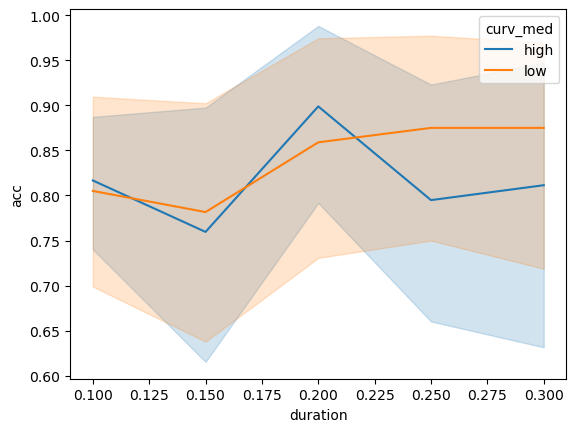

In [10]:
#create summary by duration, curv_median
curv_summary = all_sub_data.groupby(['sub','duration','curv_med'])['acc'].mean().reset_index()


#create lineplot of accuracy by duration, split by curv_median
sns.lineplot(data = curv_summary, x = 'duration', y = 'acc', hue = 'curv_med')


<Axes: xlabel='duration', ylabel='acc'>

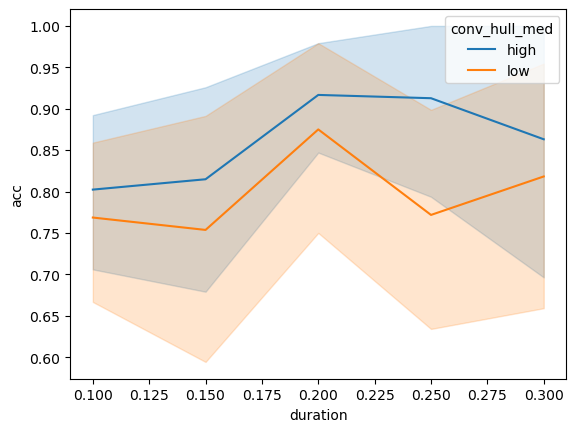

In [13]:
#create summary by duration, conv_hull_median
size_summary = all_sub_data.groupby(['sub','duration','conv_hull_med'])['acc'].mean().reset_index()
#create lineplot of accuracy by duration, split by curv_median
sns.lineplot(data = size_summary, x = 'duration', y = 'acc', hue = 'conv_hull_med')

<Axes: xlabel='duration', ylabel='acc'>

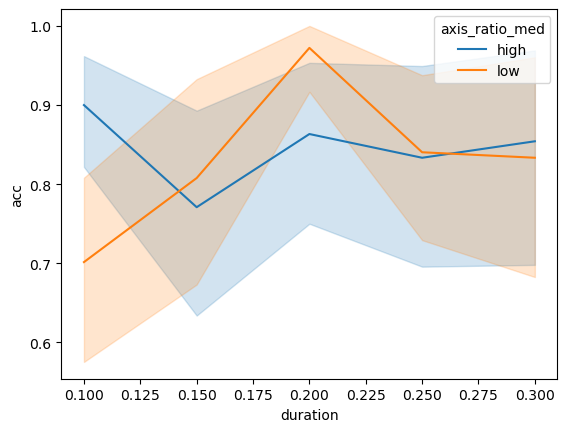

In [14]:
#create summary by duration, axis_ratio_median
size_summary = all_sub_data.groupby(['sub','duration','axis_ratio_med'])['acc'].mean().reset_index()
#create lineplot of accuracy by duration, split by curv_median
sns.lineplot(data = size_summary, x = 'duration', y = 'acc', hue = 'axis_ratio_med')

In [ ]:
from plotnine import *

summary = curv_summary

#in plotnine create line graph with x = duration, y = accuracy, fill = cond
p = ggplot(summary, aes(x='factor(duration)', y='acc', fill=curv, group = grouping)) + \
    geom_line(aes(color = grouping), stat = 'summary', size = 1.5, position = position_dodge(width=.5)) + \
    geom_linerange(aes(color = grouping),stat = 'summary', size = 1.5, position = position_dodge(width=.5)) + \
    geom_point( stat = 'summary', size = 3, position = position_dodge(width=.5)) + \
    scale_fill_manual(values = colors) + \
    scale_color_manual(values = colors) + \
    xlab('Duration (ms)') + ylab('Accuracy') + \
        theme_classic() + ylim(.4,1) + geom_hline(yintercept = .5, linetype = 'dashed', color = 'black', size = 2) + \
        theme(text = element_text(color ='black'), 
            axis_text_x= element_text(size = 14),
            axis_text_y= element_text(size = 14),
            axis_title=element_text(size = 16),
            axis_line=element_line(), 
            panel_border=element_blank(),
            figure_size = (4,3))+ \
            theme(legend_position = 'none') + \
            labs(fill='Condition') #+ ggtitle(f'{cond}')
    

#save
#p.save(f'{fig_dir}/{name}.png', dpi = 300)
print(p)
